In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
import networkx as nx
import pandas as pd

import torch
import torch.nn.functional as F
from torch.nn import LSTM
from torch_geometric.nn import GCNConv
from torch_geometric_temporal.nn.recurrent import A3TGCN2
from torch_geometric_temporal.signal import temporal_signal_split, StaticGraphTemporalSignal

from haversine import haversine

# GPU support
DEVICE = torch.device('cuda:3') # cuda
shuffle=True
batch_size = 32

In [2]:
class AirQualityDataset():
    def __init__(self, path, features=None, lat_long_vals=None, t_range=None, time_zone=None,  interval='hour', eq_weights=True):
        self.eq_weights = eq_weights
        self.interval = interval
        
        df = pd.read_csv(path)
        df['time'] = pd.to_datetime(df['time'], utc=True)
        df['locationLatitude'] = df['locationLatitude'].round(6)
        df['locationLongitude'] = df['locationLongitude'].round(6)
        cols_to_keep = ['time', 'locationLatitude', 'locationLongitude'] + list(features.keys())

        if features:
            df = df[cols_to_keep]
        if time_zone:
            df.time = df.time.dt.tz_convert(time_zone)
        if t_range:
            df = df[(df['time'] > t_range[0]) & (df['time'] < t_range[1])]
        if not lat_long_vals.empty:
            df = df.merge(lat_long_vals, on=['locationLatitude', 'locationLongitude'])

        fin_df = df.groupby(['locationLatitude', 'locationLongitude', pd.Grouper(key='time', freq='h')]).agg(features).reset_index()
        fin_df['hour'] = fin_df['time'].dt.hour
        self.locations = fin_df[['locationLatitude', 'locationLongitude']].drop_duplicates()
        self.dataset = fin_df
        # self.length = min(fin_df.groupby(['locationLatitude', 'locationLongitude']).size())
    
    def _get_edge_weights(self):
        num_nodes = len(self.locations)
        self.mapper = {i: tuple(self.locations.iloc[i]) for i in range(num_nodes)}
        self.rev_map = {tuple(self.locations.iloc[i]): i for i in range(num_nodes)}

        edges = []
        weights = []

        for i in range(num_nodes):
            for j in range(i + 1, num_nodes):
                dist = haversine(tuple(self.locations.iloc[i]), tuple(self.locations.iloc[j]))
                if dist != 0:
                    if self.eq_weights:
                        edges.append([i, j])
                        edges.append([j, i]) 
                        weights.append(1)
                        weights.append(1)
                    else:
                        attr = 1 / (1 + haversine(tuple(self.locations.iloc[i]), tuple(self.locations.iloc[j])))
                        edges.append([i, j])
                        edges.append([j, i]) 
                        weights.append(attr)
                        weights.append(attr)

        self.edges = np.array(edges).T
        self.edge_weights = np.array(weights)

    def _get_task(self, start_pred):
        assert start_pred < 24 and start_pred > 1

        fin_df = self.dataset
        self.features = []
        self.targets = []

        # features is per day
        for day in list(pd.unique(fin_df['time'].dt.date)):
            loc_list = []
            day_df = fin_df[fin_df['time'].dt.date == day]
            
            # numpy array per location per hour
            # array shape: len(locs) x features x 24
            for lat, long in self.locations.itertuples(index=False):
                features_list = []
                loc_df = day_df[(day_df['locationLatitude'] == lat) & (day_df['locationLongitude'] == long)]
                if not loc_df.empty:
                    for hr in range(24):
                        vals = loc_df[loc_df['hour'] == hr]
                        if not vals.empty:
                            features_list.append(np.array(vals.iloc[0, 3:-1]))
                        else:
                            features_list.append(np.zeros(len(fin_df.columns[3:-1])))
                    features_list_np = np.stack(features_list).T
                else:
                    features_list_np = np.zeros((len(fin_df.columns[3:-1]), 24))
                    
                loc_list.append(features_list_np)
            
            fin_arr = np.stack(loc_list).astype('float64')
            self.features.append(fin_arr[:, :, :start_pred])
            self.targets.append(fin_arr[:, :, start_pred:])
    
    def get_dataset(self, start_pred=12):
        self._get_edge_weights()
        self._get_task(start_pred)
        dataset = StaticGraphTemporalSignal(
            self.edges, self.edge_weights, self.features, self.targets
        )

        return dataset


In [ ]:
features = {
    # 'pm10ConcNumIndividual.value': 'mean',     # Sum for value1
    # 'pm1ConcNumIndividual.value': 'mean',
    'pm2_5ConcNumIndividual.value': 'mean'
    # 'relHumidInternalIndividual.value': 'mean'
}
lat_long_vals = pd.DataFrame({
    'locationLatitude': [-36.844079, -36.844113, -36.711932, -36.898491, -36.906652, -36.876728],
    'locationLongitude': [174.762123, 174.761371, 174.740808, 174.591428, 174.633079, 174.703081]
})
t_range = ['2022-04-01', '2022-12-01']
time_zone = 'Pacific/Auckland'

niwa_loader = AirQualityDataset('../../../AirData/Niwa/allNIWA_clarity.csv',
                                 features, lat_long_vals, t_range, time_zone, 'hour',
                                 False)

In [5]:
niwa_dataset = niwa_loader.get_dataset(12)

In [6]:
y = next(iter(niwa_dataset))

In [7]:
y.y[0, 0]

tensor([2.6275, 3.1367, 3.2175, 3.0733, 3.5925, 3.8333, 4.3100, 6.1367, 6.7350,
        6.6100, 6.9350, 7.0533])

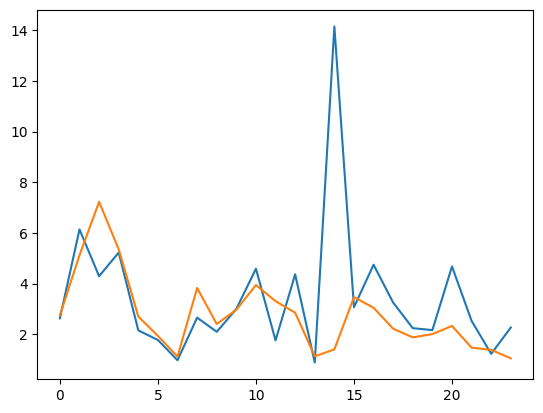

In [8]:
# Visualize traffic over time
sensor_number = 0
hours = 24
sensor_labels = [bucket.y[sensor_number][0][0].item() for bucket in list(niwa_dataset)[:hours]]
plt.plot(sensor_labels)

sensor_number = 3
hours = 24
sensor_labels = [bucket.y[sensor_number][0][0].item() for bucket in list(niwa_dataset)[:hours]]
plt.plot(sensor_labels)

# Test Train Split

In [9]:
train_dataset, test_dataset = temporal_signal_split(niwa_dataset, train_ratio=0.8)

# print("Number of train buckets: ", len(set(train_dataset)))
# print("Number of test buckets: ", len(set(test_dataset)))

In [10]:
train_input = np.array(train_dataset.features) # (195, 6, 4, 12)
train_target = np.array(train_dataset.targets) # (195, 6, 4, 12)
train_x_tensor = torch.from_numpy(train_input).type(torch.FloatTensor).to(DEVICE)  # (B, N*F, T)
train_target_tensor = torch.from_numpy(train_target).type(torch.FloatTensor).to(DEVICE)  # (B, N*F, T)


train_dataset_new = torch.utils.data.TensorDataset(train_x_tensor, train_target_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset_new, batch_size=batch_size, shuffle=shuffle,drop_last=True)

In [11]:
train_x_tensor.shape

torch.Size([195, 6, 4, 12])

In [12]:
test_input = np.array(test_dataset.features) # (49, 6, 4, 12)
test_target = np.array(test_dataset.targets) # (49, 6, 4, 12)
test_x_tensor = torch.from_numpy(test_input).type(torch.FloatTensor).to(DEVICE)  # (B, N*F, T)
test_target_tensor = torch.from_numpy(test_target).type(torch.FloatTensor).to(DEVICE)  # (B, N*F, T)

test_dataset_new = torch.utils.data.TensorDataset(test_x_tensor, test_target_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset_new, batch_size=batch_size, shuffle=shuffle,drop_last=True)

In [13]:
train_x_tensor.shape

torch.Size([195, 6, 4, 12])

In [14]:
test_target.shape

(49, 6, 4, 12)

In [15]:
test_target[:, 0, :, :].shape

(49, 4, 12)

In [16]:
test_target_tensor[0, :, :]

tensor([[[ 0.5433,  0.7075,  0.7433,  0.4700,  0.6967,  0.6350,  0.8467,
           0.8125,  0.8700,  1.7750,  2.0633,  1.6775],
         [ 0.4900,  0.6325,  0.6667,  0.4050,  0.6367,  0.5850,  0.7867,
           0.7275,  0.7900,  1.6625,  1.9467,  1.5825],
         [ 0.5100,  0.6700,  0.7000,  0.4300,  0.6567,  0.5950,  0.8100,
           0.7700,  0.8267,  1.7300,  2.0233,  1.6350],
         [51.0600, 51.6650, 51.8600, 53.6575, 55.8700, 57.6275, 60.4200,
          64.3150, 68.0333, 71.7200, 74.8967, 75.0375]],

        [[ 0.8450,  0.5733,  0.5425,  0.4600,  0.6225,  0.8200,  0.9550,
           0.7867,  7.6033,  2.1325,  1.7133,  2.0950],
         [ 0.7725,  0.5267,  0.4900,  0.4200,  0.5650,  0.7467,  0.8875,
           0.7167,  7.1367,  2.0150,  1.6233,  1.9850],
         [ 0.8100,  0.5400,  0.5050,  0.4333,  0.5925,  0.7767,  0.9225,
           0.7467,  7.5133,  2.0875,  1.6700,  2.0475],
         [57.7200, 52.4733, 52.0575, 55.8700, 59.8775, 59.4667, 63.0625,
          65.8467, 67.

# LSTM Model

In [17]:
class LSTMcell(torch.nn.Module):
    def __init__(self, initial_size, fin_emb, out_size, dropout = 0):
        super().__init__()
        # Check input size
        self.lstm1 = torch.nn.LSTMCell(initial_size, fin_emb)

        self.linear1 = torch.nn.Linear(fin_emb, 512)
        self.linear2 = torch.nn.Linear(512, 128)
        self.linear3 = torch.nn.Linear(128, out_size)

    def forward(self, x, h0, c0):
        # Feeds concatenated vector to LSTM alongside hidden layer and cell state
        hx, cx = self.lstm1(x, (h0, c0))

        h = F.relu(self.linear1(hx)) 
        h = F.relu(self.linear2(h)) 
        h = self.linear3(h)
        return h, hx, cx 

In [18]:
node_size = 6
input_size = 4
hid_size = 512
out_size = 4
periods = 12

# Create model and optimizers
model = LSTMcell(node_size*input_size, hid_size, out_size*node_size).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()


print('Net\'s state_dict:')
total_param = 0
for param_tensor in model.state_dict():
    print(param_tensor, '\t', model.state_dict()[param_tensor].size())
    total_param += np.prod(model.state_dict()[param_tensor].size())
print('Net\'s total params:', total_param)
#--------------------------------------------------
print('Optimizer\'s state_dict:')
for var_name in optimizer.state_dict():
    print(var_name, '\t', optimizer.state_dict()[var_name])

Net's state_dict:
lstm1.weight_ih 	 torch.Size([2048, 24])
lstm1.weight_hh 	 torch.Size([2048, 512])
lstm1.bias_ih 	 torch.Size([2048])
lstm1.bias_hh 	 torch.Size([2048])
linear1.weight 	 torch.Size([512, 512])
linear1.bias 	 torch.Size([512])
linear2.weight 	 torch.Size([128, 512])
linear2.bias 	 torch.Size([128])
linear3.weight 	 torch.Size([24, 128])
linear3.bias 	 torch.Size([24])
Net's total params: 1433240
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'maximize': False, 'foreach': None, 'capturable': False, 'differentiable': False, 'fused': None, 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}]


In [19]:
model

LSTMcell(
  (lstm1): LSTMCell(24, 512)
  (linear1): Linear(in_features=512, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=24, bias=True)
)

In [20]:
model.train()

for epoch in range(500):
    step = 0
    loss_list = []
    for encoder_inputs, labels in train_loader:
        encoder_inputs = torch.flatten(encoder_inputs, start_dim=1, end_dim=2).permute(0, 2, 1) # (B, T, N*F)
        labels = torch.flatten(labels, start_dim=1, end_dim=2).permute(0, 2, 1) # (B, T, N*F)

        h0 = torch.ones((labels.shape[0], hid_size)).to(DEVICE)
        h0 = torch.nn.init.xavier_uniform_(h0)
        c0 = torch.ones((labels.shape[0], hid_size)).to(DEVICE)
        co = torch.nn.init.xavier_uniform_(c0)

        losses = torch.empty(0).to(DEVICE)

        full_seq = torch.cat([encoder_inputs, labels], dim=1).to(DEVICE)

        for seq in range(23):
            if seq < 11:
                seq_cur = full_seq[:, seq, :]
            else:
                seq_cur = seq_t.detach()

            seq_t, h_t, c_t, = model(seq_cur, h0, c0)

            seq_loss = torch.sqrt(loss_fn(seq_t, full_seq[:, seq+1, :]))
            losses = torch.cat((losses, seq_loss.reshape(1)))

            h0 = h_t.detach()
            c0 = c_t.detach()
        
        loss = torch.mean(losses)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        step= step+ 1
        loss_list.append(loss.item())
        if step % 100 == 0 :
            print(sum(loss_list)/len(loss_list))
    print("Epoch {} train RMSE: {:.4f}".format(epoch, sum(loss_list)/len(loss_list)))

Epoch 0 train RMSE: 28.7732
Epoch 1 train RMSE: 25.1191
Epoch 2 train RMSE: 18.3934
Epoch 3 train RMSE: 14.6881
Epoch 4 train RMSE: 14.1957
Epoch 5 train RMSE: 13.6881
Epoch 6 train RMSE: 13.1279
Epoch 7 train RMSE: 12.6569
Epoch 8 train RMSE: 12.3870
Epoch 9 train RMSE: 11.7795
Epoch 10 train RMSE: 11.0980
Epoch 11 train RMSE: 10.5459
Epoch 12 train RMSE: 10.2090
Epoch 13 train RMSE: 9.9507
Epoch 14 train RMSE: 9.7037
Epoch 15 train RMSE: 9.5679
Epoch 16 train RMSE: 9.3877
Epoch 17 train RMSE: 9.2632
Epoch 18 train RMSE: 9.1519
Epoch 19 train RMSE: 8.9711
Epoch 20 train RMSE: 8.8125
Epoch 21 train RMSE: 8.7324
Epoch 22 train RMSE: 8.6665
Epoch 23 train RMSE: 8.4619
Epoch 24 train RMSE: 8.4726
Epoch 25 train RMSE: 8.4962
Epoch 26 train RMSE: 8.3376
Epoch 27 train RMSE: 8.4275
Epoch 28 train RMSE: 8.3450
Epoch 29 train RMSE: 8.4031
Epoch 30 train RMSE: 8.3242
Epoch 31 train RMSE: 8.3046
Epoch 32 train RMSE: 8.2114
Epoch 33 train RMSE: 8.2074
Epoch 34 train RMSE: 8.1811
Epoch 35 train RM

In [21]:
model.eval()
start_pred = 12
# Store for analysis
total_loss = []
all_y_true = []
all_y_hat = []

for encoder_inputs, labels in test_loader:
    encoder_inputs = torch.flatten(encoder_inputs, start_dim=1, end_dim=2).permute(0, 2, 1) # (B, T, N*F)
    labels = torch.flatten(labels, start_dim=1, end_dim=2).permute(0, 2, 1) # (B, T, N*F)

    pred_seq = []

    h0 = torch.ones((labels.shape[0], hid_size)).to(DEVICE)
    h0 = torch.nn.init.xavier_uniform_(h0)
    c0 = torch.ones((labels.shape[0], hid_size)).to(DEVICE)
    co = torch.nn.init.xavier_uniform_(c0)

    losses = torch.empty(0).to(DEVICE)

    full_seq = torch.cat([encoder_inputs, labels], dim=1).to(DEVICE)

    for seq in range(23):
        if seq < 11:
            seq_cur = full_seq[:, seq, :]
        else:
            pred_seq.append(seq_t)
            seq_cur = seq_t

        seq_t, h_t, c_t, = model(seq_cur, h0, c0)

        seq_loss = torch.sqrt(loss_fn(seq_t, full_seq[:, seq+1, :]))
        losses = torch.cat((losses, seq_loss.reshape(1)))

        h0 = h_t
        c0 = c_t

    # Get model predictions
    loss = torch.mean(losses[12:])
    total_loss.append(loss.item())

    all_y_hat.append(torch.stack(pred_seq))
    all_y_true.append(full_seq[:, start_pred:, :])
    # Store for analysis below
    #test_labels.append(labels)
    #predictions.append(y_hat)
    

print("Test MSE: {:.4f}".format(sum(total_loss)/len(total_loss)))

Test MSE: 6.2560


In [22]:
all_y_true = torch.cat(all_y_true, dim=0)
all_y_hat = torch.cat(all_y_hat, dim=0)

all_y_true = torch.unflatten(all_y_true, 2, (6, 4)).permute(0, 2, 3, 1)
all_y_hat = torch.unflatten(all_y_hat, 2, (6, 4)).permute(1, 2, 3, 0)

In [23]:
all_y_hat.shape, all_y_true.shape

(torch.Size([32, 6, 4, 12]), torch.Size([32, 6, 4, 12]))

(32, 6, 12) (32, 6, 12)


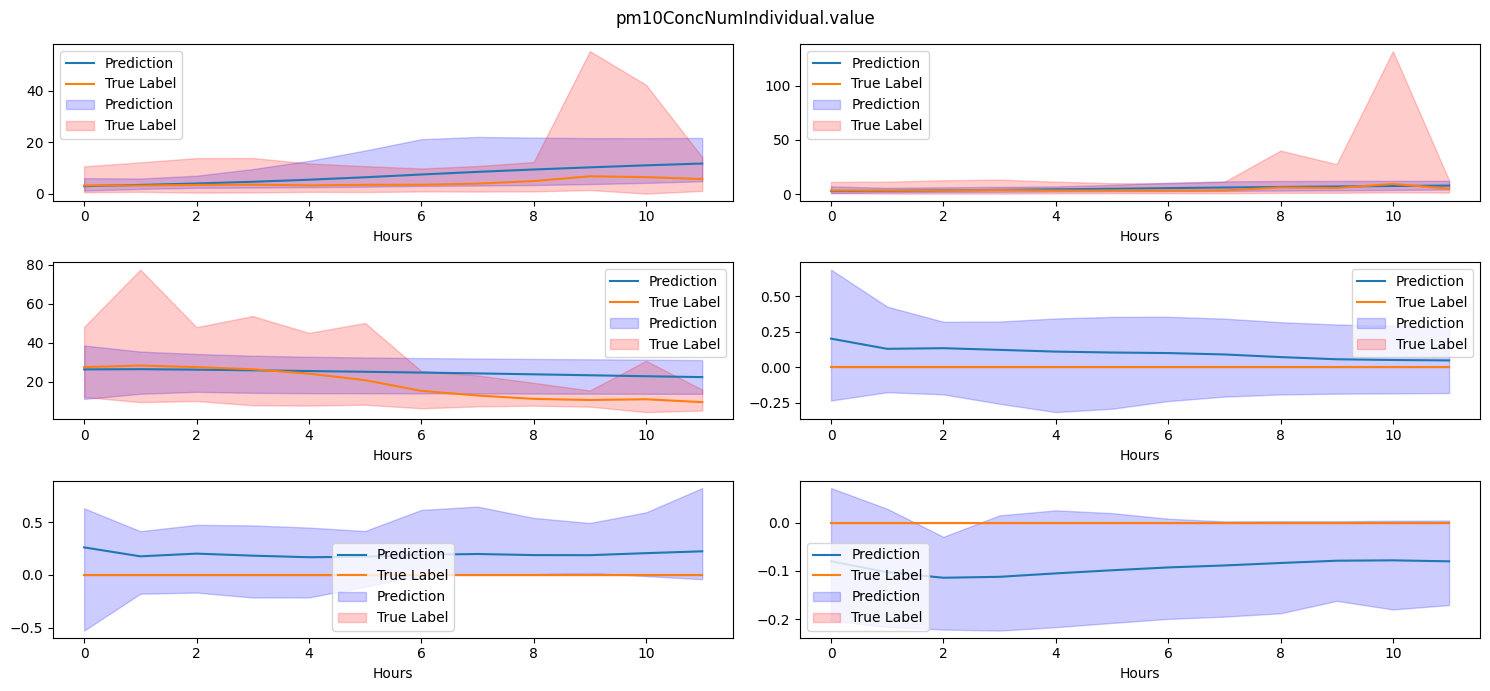

(32, 6, 12) (32, 6, 12)


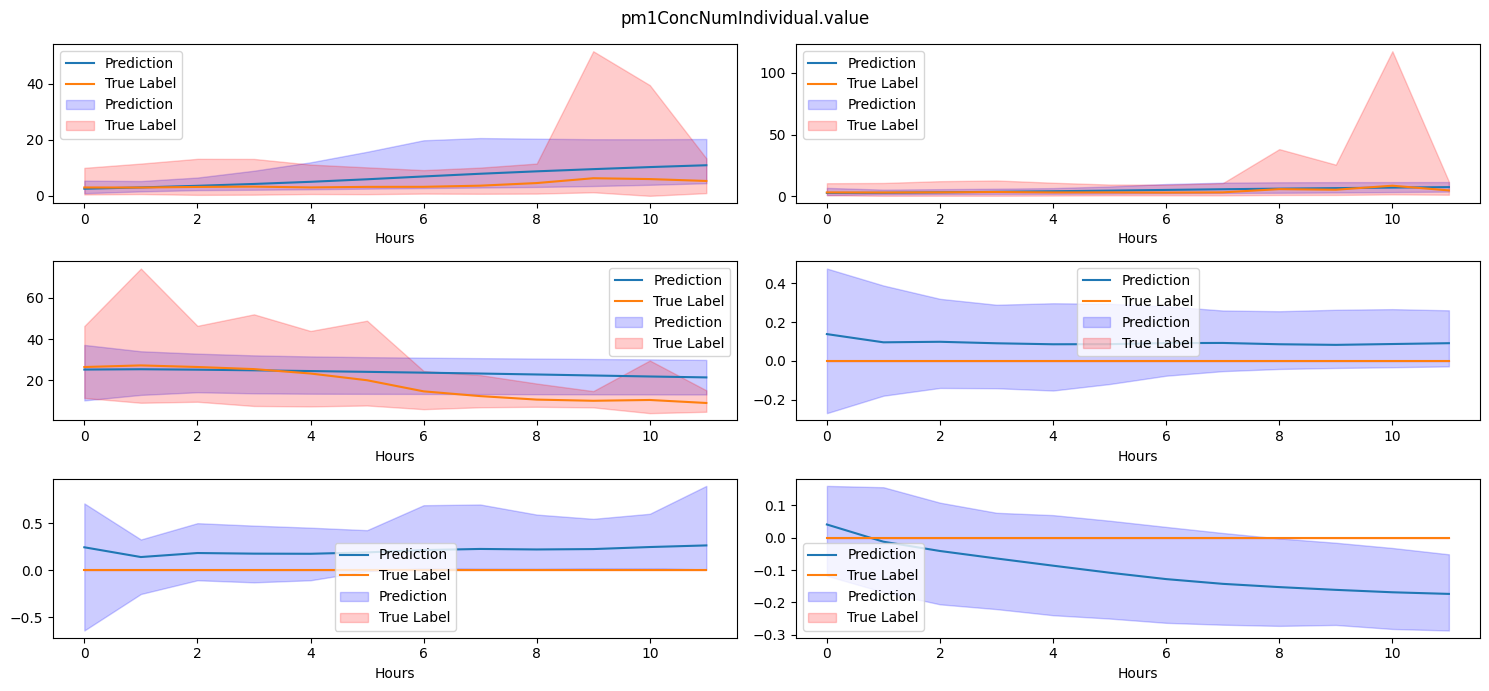

(32, 6, 12) (32, 6, 12)


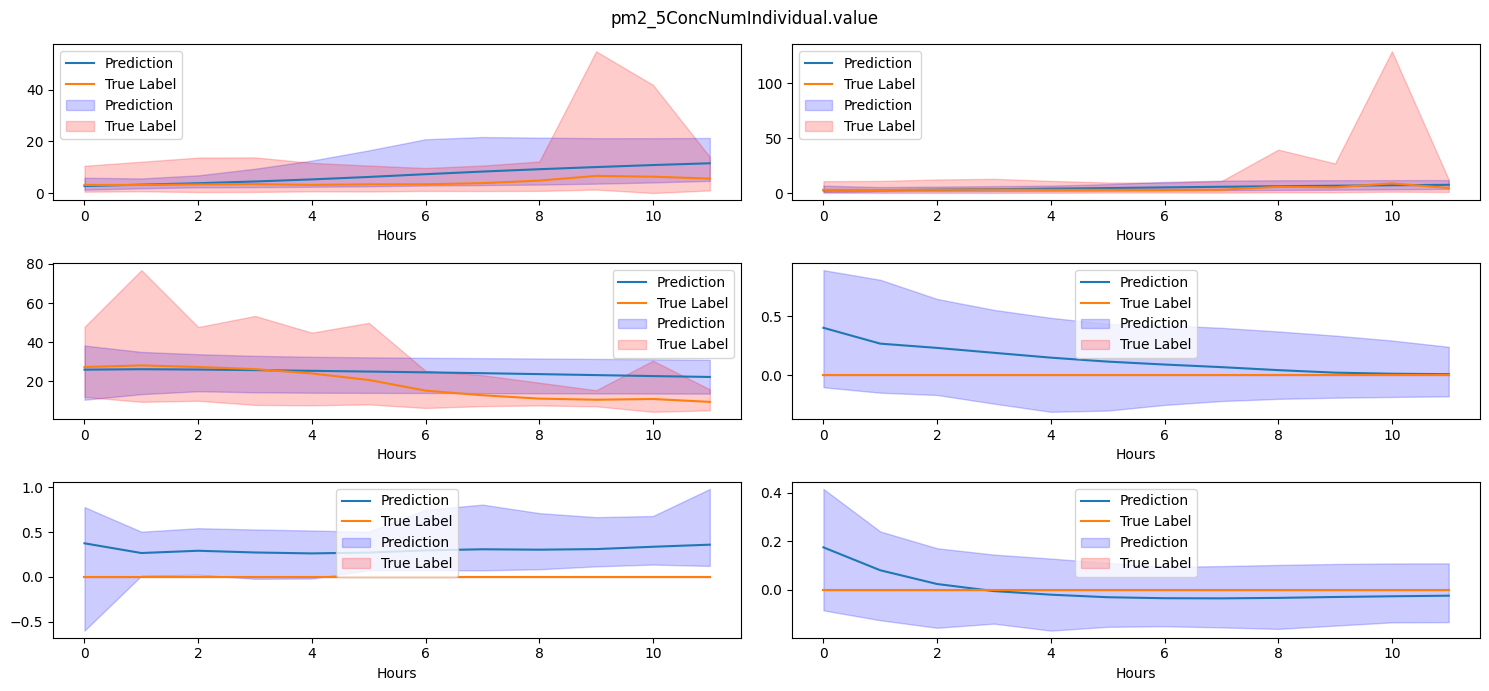

(32, 6, 12) (32, 6, 12)


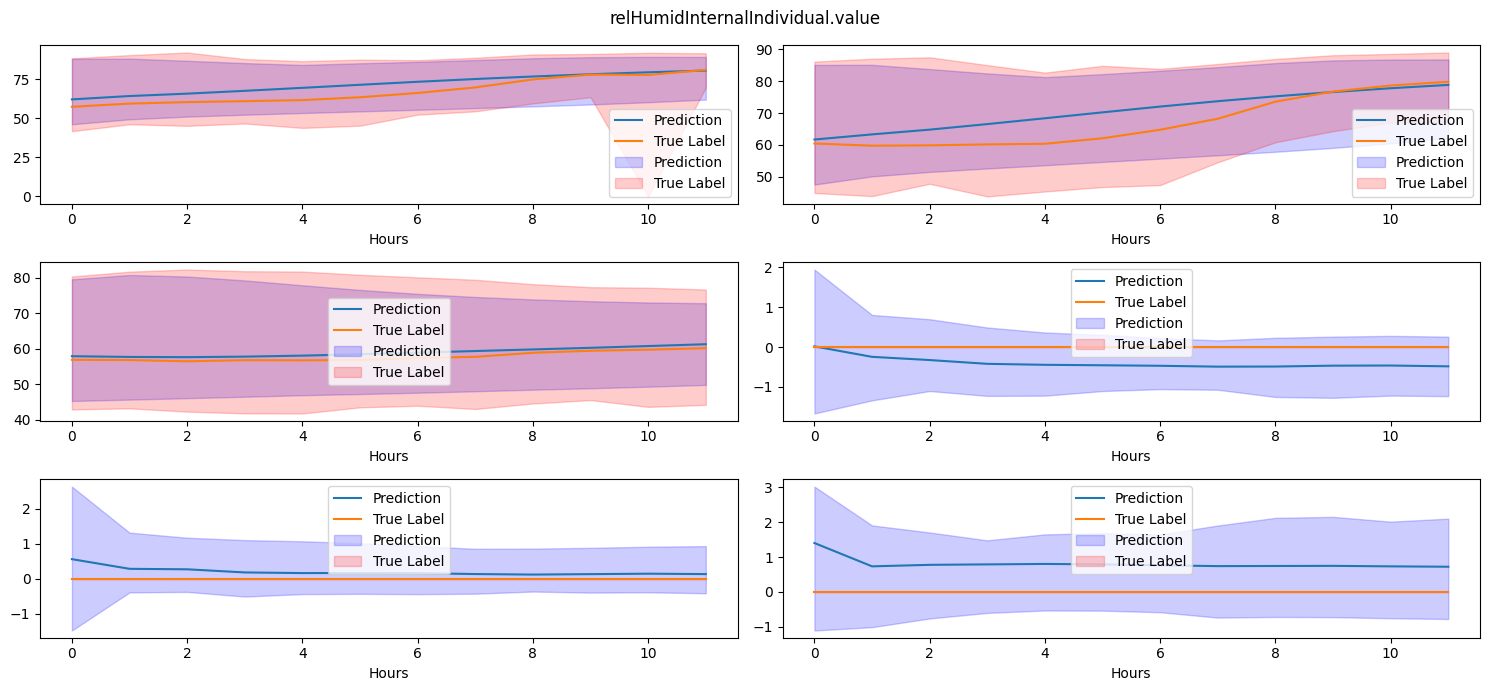

In [37]:
feat = 2

def plot_features(feat):
    # all_y_true must be (B, N, F, T)
    preds = np.asarray(all_y_hat[:, :, feat, :].detach().cpu().numpy())
    labs  = np.asarray(all_y_true[:, :, feat, :].detach().cpu().numpy())

    print(preds.shape, labs.shape)
    fig, axs = plt.subplots(3, 2, figsize=(15,7))

    for i, ax in enumerate(axs.flatten()):
        p_mean_val = np.mean(preds[:, i, :], axis=0)
        p_std_val = np.std(preds[:, i, :], axis=0)

        t_mean_val = np.mean(labs[:, i, :], axis=0)
        t_std_val = np.std(labs[:, i, :], axis=0)
        ax.plot(p_mean_val, label='Prediction')
        ax.plot(t_mean_val, label='True Label')

        # print(p_std_val, t_std_val)
        ax.fill_between(range(12), np.min(preds[:, i, :], axis=0), np.max(preds[:, i, :], axis=0),
                        color='b', alpha=0.2, label='Prediction')
        ax.fill_between(range(12), np.min(labs[:, i, :], axis=0), np.max(labs[:, i, :], axis=0),
                        color='r', alpha=0.2, label='True Label')

        ax.set_xlabel('Hours')
        ax.legend()

    fig.suptitle(f'{list(features.keys())[feat]}')
    fig.tight_layout()
    plt.show()

for i in range(4):
    plot_features(i)